Change Log

This version uses the Image_crops4 and Map_crops4 dataset. 
* Learning rate scheduler
* Dropout

In [15]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Dataset

In [0]:
import torch
import os
import cv2
from torch.utils.data import Dataset
import torchvision.transforms as Transforms
import numpy as np
import math

class dataset(Dataset):
    def __init__(self, input_folder, target_folder, model,device,validation):
        super(dataset,self).__init__()
        self.input_folder = input_folder
        self.target_folder = target_folder
        self.inputs = os.listdir(input_folder)
        self.targets = os.listdir(target_folder)
        self.targets.sort()
        self.inputs.sort()
        threshold = int(math.ceil(len(self.inputs)*0.7))
        if validation:
            ''' Uses validation set'''
            self.inputs = self.inputs[threshold:]
            self.targets = self.targets[threshold:]
        else:
            ''' uses training set '''
            self.inputs = self.inputs[0:threshold]
            self.targets = self.targets[0:threshold]
        h, w, c = cv2.imread("{}{}".format(input_folder,self.inputs[0])).shape
        self.model = model

        self.resize_shape = model(torch.zeros(1, c, h, w).to(device)).shape # Hardcoded 256 x 256
        print("Output Dimension",self.resize_shape)
        self.transform = Transforms.ToTensor()

    def __getitem__(self, index):
        image = cv2.imread(self.input_folder+self.inputs[index])
        # image = Transforms.functional.to_pil_image(image)
        # image = Transforms.functional.resize(image,256)
        image = self.transform(image)
        target = cv2.imread(self.target_folder+self.targets[index])
        target = cv2.resize(target, (self.resize_shape[2:]))
        target = np.maximum(target.astype(int)-2,0).transpose(2,0,1)[0]# Convert target from 0,3,4,5 to 0,1,2,3 therefore allowing four classes
        return [image, target]

    def __len__(self):
        return len(self.inputs)

## Network

In [0]:
import torch.nn as nn

class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels): 
        super(conv_block,self).__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class encode_layer(nn.Module):
    def __init__(self, channels, first_layer=False):
        super(encode_layer, self).__init__()

        if first_layer:
            self.layer = nn.Sequential(
                conv_block(in_channels=channels[0], out_channels=channels[1]),
                conv_block(in_channels=channels[1], out_channels=channels[1])
            )        

        else:
            self.layer = nn.Sequential(
                nn.MaxPool2d(2),
                nn.Dropout2d(p=0.1),
                conv_block(in_channels=channels[0], out_channels=channels[1]),
                conv_block(in_channels=channels[1], out_channels=channels[1])
            )

    def forward(self,x):
        x = self.layer(x)
        return x 

class decode_layer(nn.Module):
    def __init__(self,channels):
        super(decode_layer,self).__init__()

        self.upconv = nn.ConvTranspose2d(in_channels=channels[-1], out_channels=int(channels[-1]/2), kernel_size=2, stride=2)

        self.convolutions = nn.Sequential(
            conv_block(in_channels=channels[1], out_channels=channels[1]),
            conv_block(in_channels=channels[1], out_channels=channels[0])
        )

    def forward(self,x):
        x1, x2 = x
        x1 = self.upconv(x1)
        batch, c, h_x1, w_x1 = x1.shape
        batch, c, h_x2, w_x2 = x2.shape
        x2 = x2[:,:, int(h_x2/2-h_x1/2):int(h_x2/2+h_x1/2), int(w_x2/2-w_x1/2):int(w_x2/2+w_x1/2)]
        x = torch.cat((x2, x1), dim=1)
        x = nn.Dropout2d(p=0.1)(x)
        x = self.convolutions(x)
        return x

class unet(nn.Module):
    def __init__(self):
        super(unet,self).__init__()

        channels = [3, 64, 128, 256, 512, 1024]

        self.encoder0 = encode_layer(channels[0:2], first_layer=True)
        self.encoder1 = encode_layer(channels[1:3])
        self.encoder2 = encode_layer(channels[2:4])
        self.encoder3 = encode_layer(channels[3:5])
        self.encoder4 = encode_layer(channels[4:])

        self.decoder0 = decode_layer(channels[-2:])
        self.decoder1 = decode_layer(channels[-3:-1])
        self.decoder2 = decode_layer(channels[-4:-2])
        self.decoder3 = decode_layer(channels[-5:-3])

        self.final = nn.Conv2d(in_channels=channels[1], out_channels=4, kernel_size=1)

    def forward(self,x):
        x1 = self.encoder0(x)
        x2 = self.encoder1(x1)
        x3 = self.encoder2(x2)
        x4 = self.encoder3(x3)
        x5 = self.encoder4(x4)

        x6 = self.decoder0([x5, x4])
        x7 = self.decoder1([x6, x3])
        x8 = self.decoder2([x7, x2])
        x9 = self.decoder3([x8, x1])

        x = self.final(x9)

        return x
        

## Test/Validation

In [0]:
def calculate_accuracy(fx, y):
    preds = fx.max(1, keepdim=True)[1] #Argmax
    correct = preds.eq(y.view_as(preds).to(torch.long)).sum()
#     print("prediction",preds)
#     print("y",y)
    return correct

def scorer(fx, y):
  Soft=torch.nn.Softmax(dim=1)
  
  
  #preds=preds.float()
  preds=Soft(fx).argmax(dim=1)
  #preds = fx.max(1, keepdim=True)[1]
  preds=preds.cpu().data.numpy()
  y=y.cpu().data.numpy()
  #print(preds.shape)
  #print(y.shape)
  kappa = cohen_kappa_score(preds, y)
  f1_micro = f1_score(y, preds, average='micro',labels=[0,1,2,3])
  f1_macro = f1_score(y, preds, average='macro',labels=[0,1,2,3])
  return kappa+(f1_micro+f1_macro)/2

def test(model, loader,loss_fn):
    '''Calculates accuracy on a dataset'''
    model.eval()
    num_correct = []
    target_shape = []
    running_loss = 0.0
    running_score=0.0
   
    
    with torch.no_grad():
        for i, (image, target) in enumerate(loader):
            print("Forward batch {}".format(i))
            image = image.to(device)
            target = target.to(device).view(-1) # [5,324,324]->[524880]
            target_predict = model.forward(image).permute(0,2,3,1).reshape(-1,4) #[5,4,324,324]->[5,324,324,4]->[524880,4]
            loss = loss_fn(target_predict,target.to(torch.long))
            running_loss += loss.item()
            preds = target_predict.max(1, keepdim=True)[1] #Argmax
            correct = preds.eq(target.view_as(preds).to(torch.long)).sum()
            num_correct.append(correct)
            running_score+=scorer(target_predict, target )
            target_shape.append(target.shape[0])
            
            del loss
            del target_predict
            del target
            torch.cuda.empty_cache()
    running_loss /= len(loader)
    running_score/=len(loader)
    accuracy = (torch.tensor(num_correct).sum().float()/(sum(target_shape))).item()
    return running_loss, accuracy, running_score

## Training

In [0]:
import multiprocessing
from torch import optim
import time
import copy
import os


def save_model(Save_Path,model,epoch,optimizer,train_loss, train_acc, valid_loss ,valid_acc, best_acc, score):
    torch.save({
        'epoch':                 epoch,
        'model_state_dict':      model.state_dict(),
        'optimizer_state_dict':  optimizer.state_dict(),
        'train_loss':            train_loss,
        'train_acc':             train_acc,
        'valid_loss':            valid_loss,
        'valid_acc':             valid_acc,
        'best_acc':              best_acc,
        'gleason_score':         score
        
        }, Save_Path)

def train(save_dir,model_name,model,optimizer,scheduler,device,loss_fn,dataloader,valloader, best_acc = 0, start_epoch=0,n_epochs=20, train_loss = [],train_acc = [], val_loss = [], val_acc = [],score=[]):
    ''' Train the Network '''
    # Iterate through each epoch
    for epoch in range(start_epoch,n_epochs):
        print("Running Epoch No: {}".format(epoch))
        running_loss_train = 0.0
        start_time = time.time()
        num_correct = []
        target_shape = []
        model.train() # put into training mode
        for i, (image, target) in enumerate(dataloader):   #For each training batch...
            print("running batch no: {}".format(i))
            image = image.to(device) #Move images and targets to device
            target = target.to(device)
            outputs = model(image) #Forward pass through model
            new_outputs = outputs.permute(0,2,3,1).reshape(-1,4)
            new_targets = target.view(-1).long()
            loss = loss_fn(new_outputs,new_targets)#Compute cross entropy loss
            running_loss_train += loss.item()
            num_correct.append(calculate_accuracy(new_outputs, new_targets))
            target_shape.append(new_targets.shape[0])
            optimizer.zero_grad()#Gradients are accumulated, so they should be zeroed before calling backwards
            loss.backward()#Backward pass through model and update the model weights
            optimizer.step()  
        running_loss_train /= len(dataloader)
        train_loss.append(running_loss_train) # Training Loss
        # print("sum num correct",torch.tensor(num_correct).sum().float())
        # print("target_shape", target_shape)
        # print("target shape sum", sum(target_shape))
        train_acc.append((torch.tensor(num_correct).sum().float()/(sum(target_shape))).item()) # Append Training Accuracy
        vloss, vacc, score_1 = test(model,valloader,loss_fn) # Run test
        val_loss.append(vloss) # Append validation loss
        val_acc.append(vacc) # Append validation accuracy
        score.append(score_1)
        end_time = time.time()
        # Store Best Model
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1] # Save on best epoch
            Save_Path = os.path.join(save_dir, model_name + "_" + str(epoch) + "_best.pt")
            save_model(Save_Path,model,epoch,optimizer,train_loss,train_acc,val_loss,val_acc,best_acc, score)
        if (not epoch%5 ): # Save every 5 epochs
            Save_Path = os.path.join(save_dir, model_name + "_" + str(epoch) + ".pt")
            # save_model(Save_Path,model,epoch,optimizer,train_loss,train_acc,val_loss,val_acc,best_acc)
        scheduler.step()
        print('[Epoch {0:02d}] Train Loss: {1:.4f}, Train Acc: {2:.4f}, Val Loss: {3:.4f}, Val Acc: {4:.4f}, Time: {5:.4f}s'.format(
            epoch, running_loss_train,train_acc[-1], val_loss[-1], val_acc[-1],end_time - start_time))
    return train_loss, train_acc, val_loss, val_acc, score

In [0]:
import math
from sklearn.metrics import f1_score, cohen_kappa_score
#Set GPU device if available
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
# Initialise Model
model = unet().to(device)

def initweights(layer):
  
  if type(layer)==nn.Conv2d:
    kernsize=layer.kernel_size
    cin=layer.in_channels
    N=cin*kernsize[0]*kernsize[0]
    standard=math.sqrt(2/N)
    torch.nn.init.normal_(layer.weight,std=standard)
    
    
    
model.apply(initweights)

Start_From_Checkpoint = False
#Initialise Dataset
input_folder = '/content/drive/My Drive/ECE4179 - Machine Learning and Neural Networks/ECE4179 Project/Data/Image_crops4/'
target_folder = '/content/drive/My Drive/ECE4179 - Machine Learning and Neural Networks/ECE4179 Project/Data/Map_crops4/'
batch_size = 1
n_workers = multiprocessing.cpu_count()
trainset = dataset(input_folder, target_folder, model,device,False)
valset = dataset(input_folder,target_folder,model,device,True)
#Initialise Dataloader
dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                        shuffle=True, num_workers=n_workers)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                        shuffle=True, num_workers=n_workers)
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 40)
loss_fn = nn.CrossEntropyLoss()
save_dir = '/content/drive/My Drive/ECE4179 - Machine Learning and Neural Networks/ECE4179 Project/Results/V3/Run2'
model_name = 'Unet'
#Create Save Path from save_dir and model_name, we will save and load our checkpoint here
# Save_Path = os.path.join(save_dir, model_name + ".pt")
Load_Path = os.path.join(save_dir, model_name + ".pt")

#Setup defaults:
start_epoch = 0
best_valid_acc = 0
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []
scores=[]
#Create the save directory if it does note exist
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

#Load Checkpoint
if Start_From_Checkpoint:
    #Check if checkpoint exists
    if os.path.isfile(Load_Path):
        #load Checkpoint
        check_point = torch.load(Load_Path)
        #Checkpoint is saved as a python dictionary
        model.load_state_dict(check_point['model_state_dict'])
        optimizer.load_state_dict(check_point['optimizer_state_dict'])
        start_epoch = check_point['epoch']
        best_valid_acc = check_point['best_acc']
        train_loss = check_point['train_loss']
        train_acc = check_point['train_acc']
        valid_loss = check_point['valid_loss']
        valid_acc = check_point['valid_acc']
        score= check_point['gleason_score']
        #confusion = check_point['conf']
        
        print("Checkpoint loaded, starting from epoch:", start_epoch)
    else:
        #Raise Error if it does not exist
        raise ValueError("Checkpoint Does not exist")
else:
    #If checkpoint does exist and Start_From_Checkpoint = False
    #Raise an error to prevent accidental overwriting
    if os.path.isfile(Load_Path):
        raise ValueError("Warning Checkpoint exists")
    else:
        print("Starting from scratch")
out = train(save_dir,model_name,model,optimizer,scheduler,device,loss_fn,dataloader,valloader,best_valid_acc,start_epoch,n_epochs=40,train_loss = train_loss,train_acc=train_acc, val_loss = valid_loss, val_acc = valid_acc, score=scores)

## Confusion Matrix

**PseudoCode**

* Create blank 4x4 matrix. 
 * Rows are the actual classification. Columns are the predicted class. 
* Loop through each validation image.
 * Loop through each pixel in the validation image.
 * Use the labels to indicate the Row and Column of the confusion matrix.
 * Increment that particular position in the confusion matrix

In [0]:
confusion=np.zeros([4,4])

model.eval()

with torch.no_grad():
    for i, (image, target) in enumerate(valloader):
        print("confusion addition - batch {}".format(i))
        image = image.to(device)
        target = target.to(device).view(-1) # [5,324,324]->[524880]
        target_predict = model.forward(image).permute(0,2,3,1).reshape(-1,4) #[5,4,324,324]->[5,324,324,4]->[524880,4]
        
        preds = target_predict.max(1, keepdim=True)[1]
        for p in range(target.shape[0]):
          current_target=target[p]
          current_pred=preds[p,0]
          confusion[current_target,current_pred]+=1
        

        torch.cuda.empty_cache()

confusion addition - batch 0
confusion addition - batch 1
confusion addition - batch 2
confusion addition - batch 3
confusion addition - batch 4
confusion addition - batch 5
confusion addition - batch 6
confusion addition - batch 7
confusion addition - batch 8
confusion addition - batch 9
confusion addition - batch 10
confusion addition - batch 11
confusion addition - batch 12
confusion addition - batch 13
confusion addition - batch 14
confusion addition - batch 15
confusion addition - batch 16
confusion addition - batch 17
confusion addition - batch 18
confusion addition - batch 19
confusion addition - batch 20
confusion addition - batch 21
confusion addition - batch 22
confusion addition - batch 23
confusion addition - batch 24
confusion addition - batch 25
confusion addition - batch 26
confusion addition - batch 27
confusion addition - batch 28
confusion addition - batch 29
confusion addition - batch 30
confusion addition - batch 31
confusion addition - batch 32
confusion addition -

In [0]:
confusion

array([[1.2829701e+07, 1.1968200e+05, 5.8704800e+05, 0.0000000e+00],
       [9.2326700e+05, 2.4611600e+05, 1.3243640e+06, 0.0000000e+00],
       [8.9717600e+05, 2.6872900e+05, 2.2303900e+06, 0.0000000e+00],
       [2.1610000e+03, 1.3130000e+03, 6.7410000e+03, 0.0000000e+00]])

In [0]:
sumconf=np.sum(confusion,axis=1)
#print(sumconf)
fconf=np.zeros([4,4])
for cc in range(4):
  fconf[cc,:]=confusion[cc,:]/sumconf[cc]
  
print(fconf)
print(sumconf)

[[0.94779052 0.00884147 0.043368   0.        ]
 [0.37023283 0.09869325 0.53107392 0.        ]
 [0.26416315 0.07912416 0.65671268 0.        ]
 [0.21155164 0.12853647 0.65991189 0.        ]]
[1.3536431e+07 2.4937470e+06 3.3962950e+06 1.0215000e+04]


40


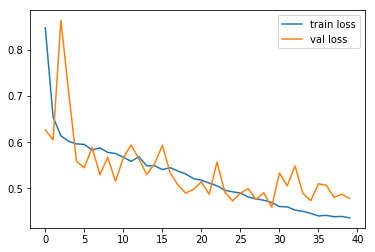

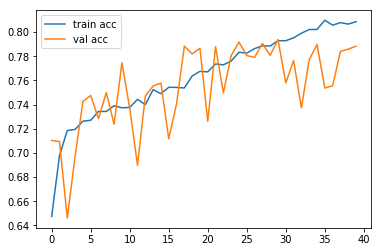

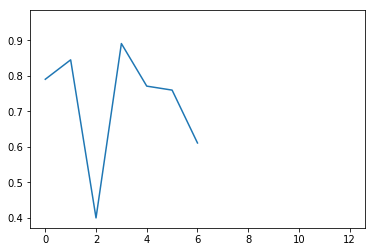

In [0]:
import matplotlib.pyplot as plt
plt.plot(out[0], label="train loss")
plt.plot(out[2], label="val loss")
plt.legend()
plt.figure()
plt.plot(out[1], label="train acc")
plt.plot(out[3], label="val acc")
plt.legend()
plt.figure()
plt.plot(out[4])



In [0]:
print(out[4])

[0.7901973785584067, 0.8449130822713904, 0.399774551597046, 0.8907798788467132, 0.7708893801396622, 0.7596658463153673, 0.610849893364417, nan, 0.9049348728877212, nan, 0.9501539823516876, nan, 0.9563962556992114, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


In [16]:
import math
from sklearn.metrics import f1_score, cohen_kappa_score
#Set GPU device if available
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
# Initialise Model
model = unet().to(device)

#Initialise Dataset
input_folder = '/content/drive/My Drive/ECE4179 Project/Data/Image_crops4/'
target_folder = '/content/drive/My Drive/ECE4179 Project/Data/Map_crops4/'
batch_size = 1
n_workers = multiprocessing.cpu_count()
trainset = dataset(input_folder, target_folder, model,device,False)
valset = dataset(input_folder,target_folder,model,device,True)
#Initialise Dataloader
dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                        shuffle=True, num_workers=n_workers)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                        shuffle=True, num_workers=n_workers)

Load_Path = '/content/drive/My Drive/ECE4179 Project/Results/V3/Run2/Unet_29_best.pt'


#Load Checkpoint
if os.path.isfile(Load_Path):
    #load Checkpoint
    check_point = torch.load(Load_Path)
    #Checkpoint is saved as a python dictionary
    model.load_state_dict(check_point['model_state_dict'])
    start_epoch = check_point['epoch']
    best_valid_acc = check_point['best_acc']
    train_loss = check_point['train_loss']
    train_acc = check_point['train_acc']
    valid_loss = check_point['valid_loss']
    valid_acc = check_point['valid_acc']
    score= check_point['gleason_score']
    #confusion = check_point['conf']

    print("Checkpoint loaded, starting from epoch:", start_epoch)
else:
    #Raise Error if it does not exist
    raise ValueError("Checkpoint Does not exist")



Output Dimension torch.Size([1, 4, 516, 516])
Output Dimension torch.Size([1, 4, 516, 516])
Checkpoint loaded, starting from epoch: 29


In [0]:
model.eval()
scores = np.zeros(len(valloader))
with torch.no_grad():
    for i, (image, target) in enumerate(valloader):
        image = image.to(device)
        target = target.to(device).view(-1) # [5,324,324]->[524880]
        target_predict = model.forward(image).permute(0,2,3,1).reshape(-1,4) #[5,4,324,324]->[5,324,324,4]->[524880,4]
        
        score = scorer(target_predict, target)
        scores[i] = score

        torch.cuda.empty_cache()
        


In [22]:
print(scores[~np.isnan(scores)].mean())
print(scores)

0.9685730797336978
[1.39883772 0.8167963  0.61218448 0.54445177 0.8407987  1.57804482
 0.6619187  1.17204196 1.46064014 1.21281624 0.94382648 1.57644725
 0.55351026 1.56449472        nan 0.59999547 0.5342405  0.68353139
 0.7981477  0.78248354 0.70340501 0.62333286 0.77038343 0.87140987
 1.36772494 1.06416259 1.53074477 1.12075085 0.9495633  1.25809993
 1.51812884 1.64018948 0.85280094 0.77765659 1.63109336 0.75137945
 0.67504792 1.40991868 0.62495986 1.57871446 0.94408046 0.62172503
 0.59848444 0.73435022 0.73344047 1.1900571  0.62499789 1.51532903
        nan 0.61919538 0.77436588 1.56051695 1.03544589 0.85904718
 1.60090653 0.72863783 0.5793451  0.92623701 0.60306024 0.65592289
 0.72854968 1.39205112 0.7125737  1.17385889 0.62261639 1.26140871
 0.93526994 0.67530962 0.61932228 0.68795486 0.64800551 1.31023998
 1.04170721]


In [23]:
confusion=np.zeros([4,4])

model.eval()

with torch.no_grad():
    for i, (image, target) in enumerate(valloader):
        print("confusion addition - batch {}".format(i))
        image = image.to(device)
        target = target.to(device).view(-1) # [5,324,324]->[524880]
        target_predict = model.forward(image).permute(0,2,3,1).reshape(-1,4) #[5,4,324,324]->[5,324,324,4]->[524880,4]
        
        preds = target_predict.max(1, keepdim=True)[1]
        for p in range(target.shape[0]):
          current_target=target[p]
          current_pred=preds[p,0]
          confusion[current_target,current_pred]+=1
        

        torch.cuda.empty_cache()

confusion addition - batch 0
confusion addition - batch 1
confusion addition - batch 2
confusion addition - batch 3
confusion addition - batch 4
confusion addition - batch 5
confusion addition - batch 6
confusion addition - batch 7
confusion addition - batch 8
confusion addition - batch 9
confusion addition - batch 10
confusion addition - batch 11
confusion addition - batch 12
confusion addition - batch 13
confusion addition - batch 14
confusion addition - batch 15
confusion addition - batch 16
confusion addition - batch 17
confusion addition - batch 18
confusion addition - batch 19
confusion addition - batch 20
confusion addition - batch 21
confusion addition - batch 22
confusion addition - batch 23
confusion addition - batch 24
confusion addition - batch 25
confusion addition - batch 26
confusion addition - batch 27
confusion addition - batch 28
confusion addition - batch 29
confusion addition - batch 30
confusion addition - batch 31
confusion addition - batch 32
confusion addition -

In [24]:
confusion

array([[1.2657078e+07, 1.6853200e+05, 7.1082100e+05, 0.0000000e+00],
       [7.4680800e+05, 2.8270000e+05, 1.4642390e+06, 0.0000000e+00],
       [6.4987500e+05, 2.3548800e+05, 2.5109320e+06, 0.0000000e+00],
       [8.6500000e+02, 2.4800000e+02, 9.1020000e+03, 0.0000000e+00]])

In [25]:
sumconf=np.sum(confusion,axis=1)
#print(sumconf)
fconf=np.zeros([4,4])
for cc in range(4):
  fconf[cc,:]=confusion[cc,:]/sumconf[cc] 
  
print(fconf)
print(sumconf)

[[0.93503805 0.01245025 0.0525117  0.        ]
 [0.29947224 0.11336354 0.58716422 0.        ]
 [0.19134822 0.06933673 0.73931505 0.        ]
 [0.08467939 0.02427802 0.89104258 0.        ]]
[1.3536431e+07 2.4937470e+06 3.3962950e+06 1.0215000e+04]
